<a href="https://colab.research.google.com/github/1oneweeek/TIL/blob/main/OD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Object Detection ch.1

바운딩 박스 표시와 IoU 계산 방법을 공부하기 위한 코드로 IoU 값이 상대적으로 큰 의미가 있지 않음.

100%|██████████| 170498071/170498071 [00:01<00:00, 85565599.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


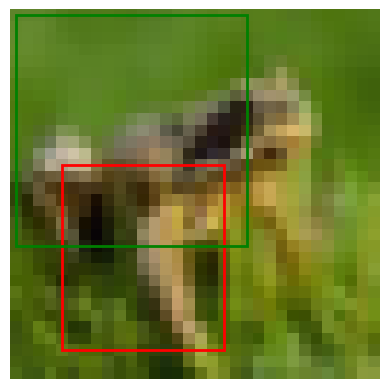

IoU: 0.1863117814064026


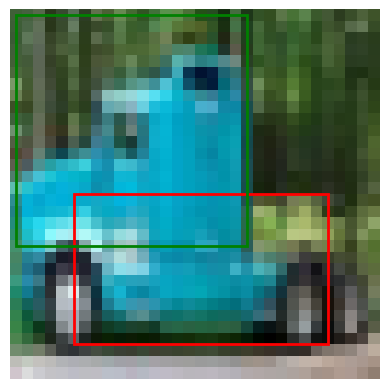

IoU: 0.10913500189781189


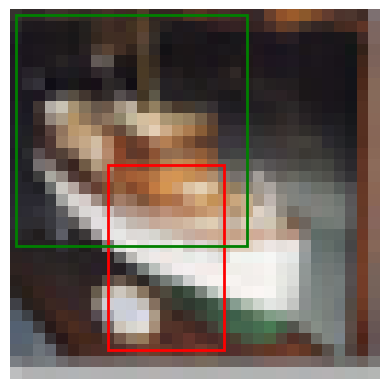

IoU: 0.1428571492433548


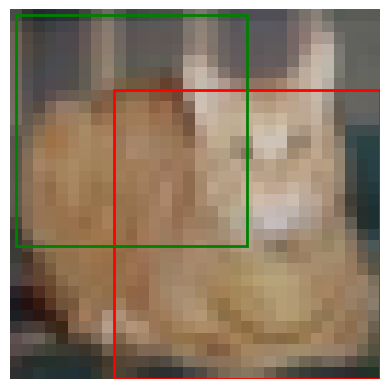

IoU: 0.1893870085477829


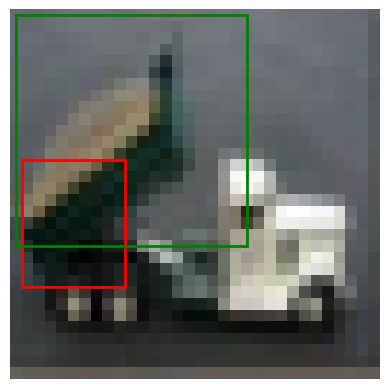

IoU: 0.15643104910850525


In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 데이터셋 로드
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# 임의로 바운딩 박스 설정
def get_random_bbox(img):
    _, _, h, w = img.shape

    x_center = np.random.randint(0, w)
    y_center = np.random.randint(0, h)

    max_width = min(w - x_center, x_center) * 2 - 1
    max_height = min(h - y_center, y_center) * 2 - 1

    if max_width <= 0:
        max_width = 1
    if max_height <= 0:
        max_height = 1

    low_width = min(10, max_width)
    low_height = min(10, max_height)

    width = np.random.randint(low_width, max_width + 1)
    height = np.random.randint(low_height, max_height + 1)

    bbox = torch.tensor([[x_center, y_center, width, height]], dtype=torch.float32)

    return bbox

# IoU 계산 함수
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  # boxes_preds shape is (N, 4) where N is the number of bboxes
  # boxes_preds shape is (N, 4)

    """
  Calculates intersection over union

  Parameters:
      boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
      boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
      box_format (str): midpoint/corners, if boxes (x, y, w, h) or (x1, y1, x2, y2)

  Returns:
      tensor: Intersection over union for all examples
  """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# 이미지와 바운딩 박스 시각화
def visualize_bbox(img, bbox_true, bbox_pred):

    img = img.permute(1, 2, 0).numpy()
    bbox_true = bbox_true[0].numpy()
    bbox_pred = bbox_pred[0].numpy()

    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((bbox_true[0]-bbox_true[2]/2, bbox_true[1]-bbox_true[3]/2), bbox_true[2], bbox_true[3], fill=False, edgecolor='r', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((bbox_pred[0]-bbox_pred[2]/2, bbox_pred[1]-bbox_pred[3]/2), bbox_pred[2], bbox_pred[3], fill=False, edgecolor='g', linewidth=2))
    plt.axis('off')
    plt.show()

# 데이터셋에서 이미지와 바운딩 박스 추출 및 시각화
for idx, (images, labels) in enumerate(train_loader):
    if idx >= 5:
        break

    bbox_true = get_random_bbox(images)

    # 바운딩 박스 예측(임의로 설정)
    bbox_pred = torch.tensor([[10, 10, 20, 20]], dtype=torch.float32)

    # 이미지와 바운딩 박스 시각화
    visualize_bbox(images[0], bbox_true, bbox_pred)

    # IoU 계산
    iou = intersection_over_union(bbox_pred, bbox_true, box_format="midpoint")
    print(f"IoU: {iou.item()}")

2. Object Detection ch.2

Non-Maximum Suppression, NMS(비최대억제): 객체 검출 모델의 출력에서 겹치는 박스를 제거하여 중복된 검출을 줄이는 기법

In [ ]:
import torch

def non_max_suppression(
    bboxes,
    iou_threshold,
    threshold,
    box_format="corners"
):
  # predictions = [[1, 0.9, x1, y1, x2, y2]]

  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > threshold]
  bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
        box
        for box in bboxes
        if box[0] != chosen_box[0]
        or intersection_over_union(
            torch.tensor(chosen_box[2:]),
            torch.tensor(box[2:]),
            box_format=box_format,
        )
        < iou_threshold
    ]

    bboxes_after_nms.append(chosen_box)

  return bboxes_after_nms

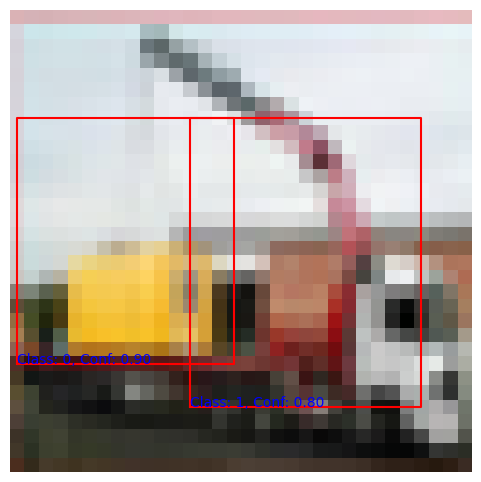

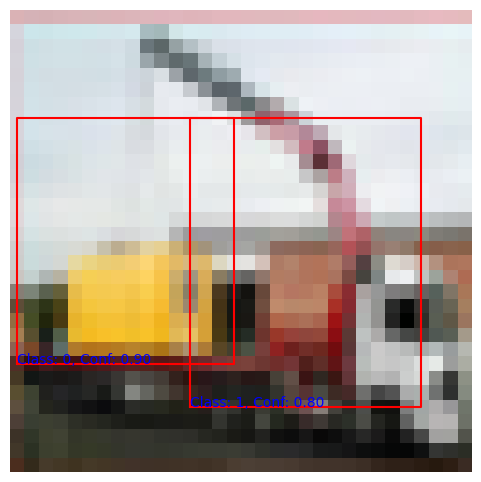

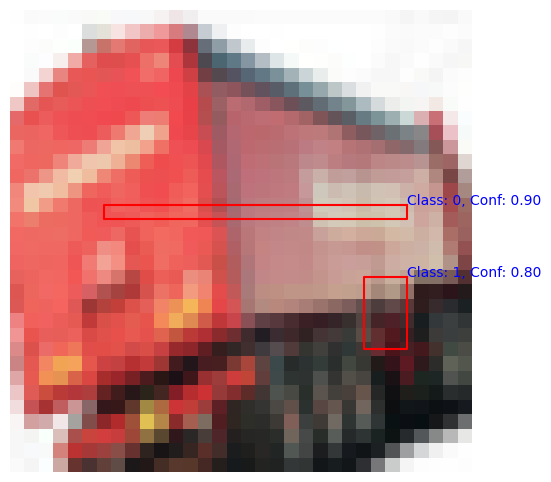

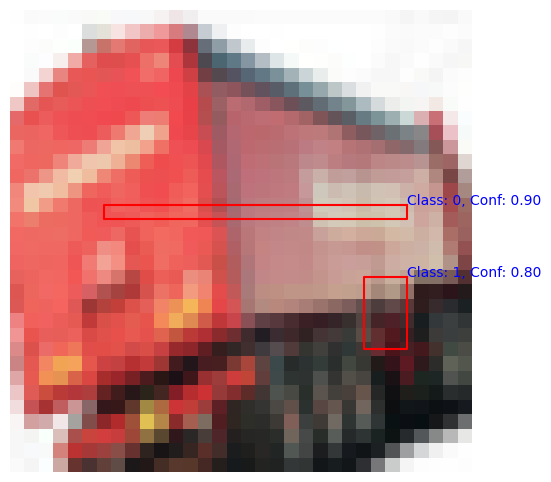

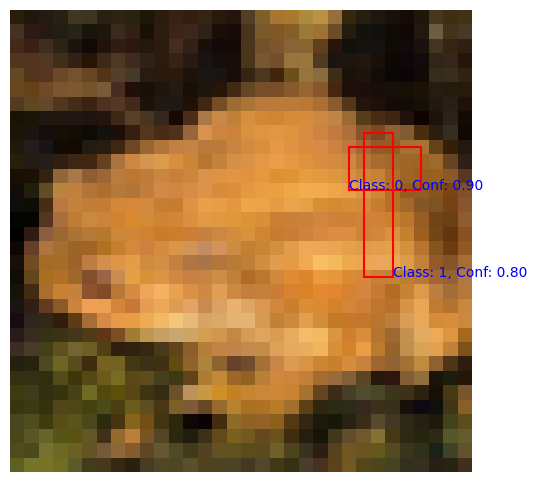

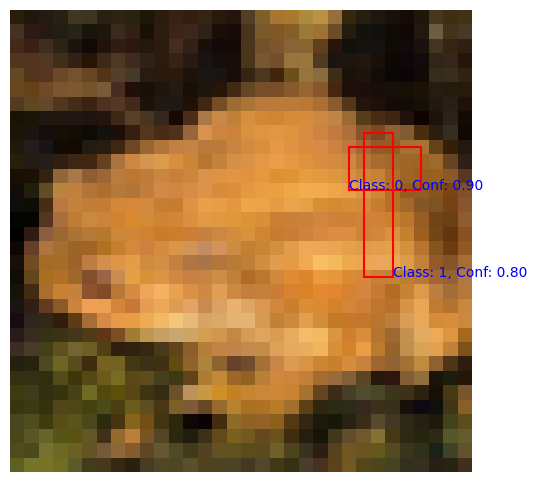

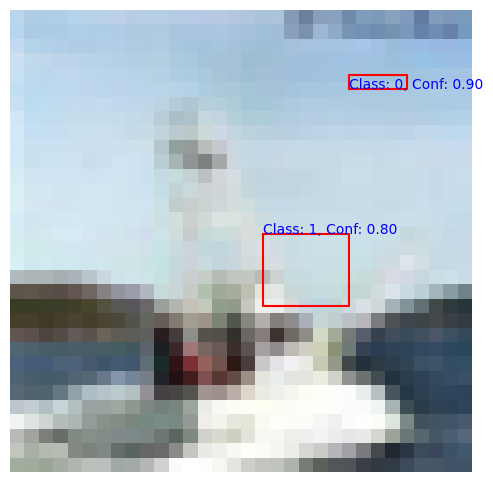

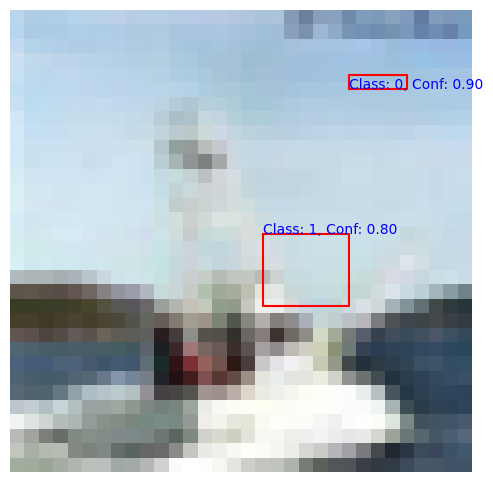

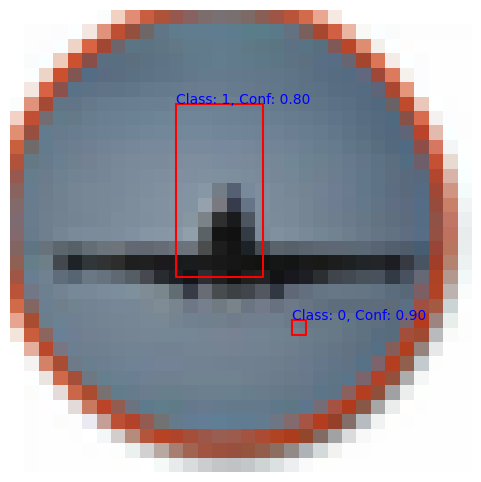

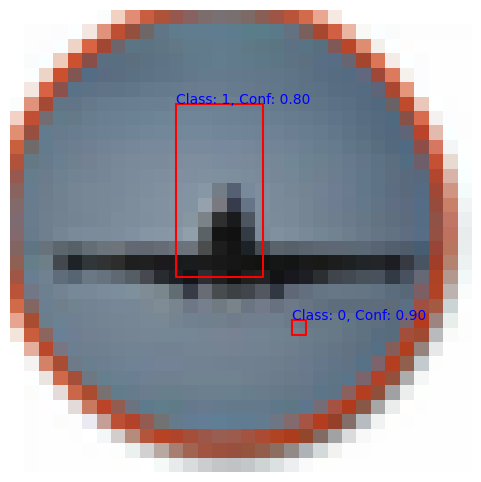

In [ ]:
# CIFAR-10 데이터셋에 NMS 알고리즘 적용

def plot_image_with_boxes(image, bboxes):
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')

    for box in bboxes:
        class_label, confidence, x1, y1, x2, y2 = box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
        plt.text(x1, y1, f'Class: {class_label}, Conf: {confidence:.2f}', color='b')

    plt.show()

for i, (images, labels) in enumerate(train_loader):
    if i >= 5:
        break

    image = images[0]

    # 랜덤 박스 생성
    bboxes = [
    [0, 0.9, np.random.randint(0, 28), np.random.randint(0, 28), np.random.randint(4, 31), np.random.randint(4, 31)],
    [1, 0.8, np.random.randint(0, 28), np.random.randint(0, 28), np.random.randint(4, 31), np.random.randint(4, 31)]
]

    plot_image_with_boxes(image, bboxes)

    # NMS 적용
    bboxes_after_nms = non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.5)

    plot_image_with_boxes(image, bboxes_after_nms)

3. Object Detection ch.3

Mean Average Precision(MAP)

In [ ]:
import torch
from collections import Counter

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format='corners', num_classes=20
):
    # pred_boxes(list): [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
      detections = []
      ground_truths = []

      # 예측된 박스와 실제 박스를 클래스별로 분리
      for detection in pred_boxes:
        if detection[1] == c:
          detections.append(detection)

      for true_box in true_boxes:
        if true_box[1] == c:
          ground_truths.append(true_box)

      # 각 이미지별 실제 바운딩 박스의 수 계산
      # img 0 has 3 boxes
      # img 1 has 5 boxes
      # amount_boxxes = {0:3, 1:5}
      amount_bboxes = Counter([gt[0] for gt in ground_truths])

      for key, val in amount_bboxes.items():
        amount_bboxes[key] = torch.zeros(val)

      # 예측된 바운딩 박스를 신뢰도에 따라 내림차순으로 정렬
      # amount_boxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])}
      detections.sort(key=lambda x: x[2], reverse=True)
      TP = torch.zeros((len(detections)))
      FP = torch.zeros((len(detections)))
      total_true_bboxes = len(ground_truths)

      # 예측된 바운딩 박스와 실제 바운딩 박스 간의 IoU 계산 및 mAP 계산
      for detection_idx, detection in enumerate(detections):
        ground_truth_img = [
            bbox for bbox in ground_truths if bbox[0] == detection [0]
        ]

        num_gts = len(ground_truth_img)
        best_iou = 0

        for idx, gt in enumerate(ground_truth_img):
          iou = intersection_over_union(
              torch.tensor(detection[3:]),
              torch.tensor(gt[3:]),
              box_format=box_format,
          )
          if iou > best_iou:
            best_iou = iou
            best_gt_idx = idx

        if best_iou > iou_threshold:
          if amount_bboxes[detection[0]][best_gt_idx] == 0:
            TP[detection_idx] = 1
            amount_bboxes[detection[0]][best_gt_idx] = 1
          else:
            FP[detection_idx] = 1

        else:
          FP[detection_idx] = 1

      # 정밀도와 재현율 계산
      # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
      TP_cumsum = torch.cumsum(TP, dim=0)
      FP_cumsum = torch.cumsum(FP, dim=0)
      recalls = TP_cumsum / (total_true_bboxes + epsilon)
      precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
      precisions = torch.cat((torch.tensor([1]), precisions))
      recalls = torch.cat((torch.tensor([0]), recalls))
      average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)